<a href="https://colab.research.google.com/github/mohammedterry/ANNs/blob/master/ANN_NeuroEvo_ELM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:
!curl -O https://pmcvariety.files.wordpress.com/2018/04/twitter-logo.jpg?w=100&h=100&crop=1
!ls

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3593  100  3593    0     0  16331      0 --:--:-- --:--:-- --:--:-- 16331
 sample_data  'twitter-logo.jpg?w=100'


In [0]:
from PIL import Image
image = Image.open('twitter-logo.jpg?w=100')

In [0]:
import numpy as np
image_array = np.asarray(image)

In [0]:
training_inputs,training_outputs = [],[]
for row,rgbs in enumerate(image_array):
  for column,rgb in enumerate(rgbs):
    training_inputs.append(np.array([row,column]))
    r,g,b = rgb
    training_outputs.append(np.array([r/255,g/255,b/255]))

# NeuroEvolution

In [0]:
import numpy as np

class FFNN:
  def __init__(self, weights):
    self.weights = weights
  
  def _f(self,x): #activation function: sigmoid
    return 1. / (1. + np.exp(-x))
  
  def __call__(self, x): #forward pass through each layer in the deep ffnn
    for w in self.weights:
      x = self._f(x @ w)
    return x

class GA:
  global_fitness = 0
  evolutionary_history = [0]
  best_genomes = []
  #hyperparameters
  n_hidden = 15
  max_generations = 1000
  population_size = 100
  p_mutate_weight = .8
  p_mutate_layer = .03

  def __init__(self,n_inputs,n_outputs,x_test,y_test):
    self.genomes = [[np.random.rand(n_inputs,self.n_hidden),np.random.rand(self.n_hidden,n_outputs)] for _ in range(self.population_size)]  #each genome is a 2D matrix of synapse weights for each layer in ffnn
    self.n_outputs = n_outputs
    self.x_test = x_test
    self.y_test = y_test
    
  def fitness(self, weights):
    ann = FFNN(weights)
    y_predicted = np.array([ann(x) for x in self.x_test])
    difference = np.sum(self.y_test - y_predicted) 
    return 1/difference
  
  def rank(self,genomes):
    fitnesses = []
    for genome in genomes:
      fitnesses.append(self.fitness(genome))  #measure the fitness of each genome
      if fitnesses[-1] > self.global_fitness: #store the fittest genomes
        self.global_fitness = fitnesses[-1]
        self.best_genomes = [genome]
      elif fitnesses[-1] == self.global_fitness:
        self.best_genomes.append(genome)   
    return [genomes[i] for _,i in sorted(zip(fitnesses,[i for i in range(len(fitnesses))]), reverse=True)] #rank genomes by fitness

  def mutate(self,genomes):
    def noise(x):
      return x + np.random.uniform(-.1,.1) if np.random.random() <= self.p_mutate_weight else x
    noise = np.vectorize(noise) 

    for i,weights in enumerate(genomes):   
      genomes[i] = [noise(layer) for layer in weights] #change some weights
      if np.random.random() <= self.p_mutate_layer: #add another hidden layer 
        pointer = np.random.randint(1,len(weights)) #add it inbetween the input and output layers
        genomes[i] = weights[:pointer] + [np.random.rand(self.n_hidden,self.n_hidden)] + weights[pointer:]                  
    return genomes
  
  def crossover(self,genome1,genome2): #one-point crossover
    pointer1 = np.random.randint(1,len(genome1))
    pointer2 = np.random.randint(1,len(genome2))
    new_genome1 = genome1[:pointer1] + genome2[pointer2:]
    new_genome2 = genome2[:pointer2] + genome1[pointer1:]
    return new_genome1, new_genome2
  
  def mate(self,genome1,genome2):
    child1,child2 = self.crossover(genome1,genome2)
    return genome1, genome2, child1, child2 # returns x2 parents & x2 children (i.e. mixtures of both parents)
  
  def g_algorithm(self):
    elites = self.rank(self.genomes)[:self.population_size // 4] #keep top quarter for mating 
    offspring = [child for parent1,parent2 in zip(elites,random.sample(elites, len(elites))) for child in self.mate(parent1,parent2) ]  #elite's offspring replace population (4 children for every genome)
    self.genomes = self.mutate(offspring)
    
  def evolve(self):
    for _ in range(self.max_generations):
      self.g_algorithm()
      self.evolutionary_history.append(self.global_fitness)
    return sorted(self.best_genomes, key=lambda x: len(x)) #rank best solutions by network size (to give preference to smaller evolved nns)
      

In [0]:
g = GA(2,3,training_inputs,training_outputs)
best_weights = g.evolve()[0]

Text(0, 0.5, 'fitness')

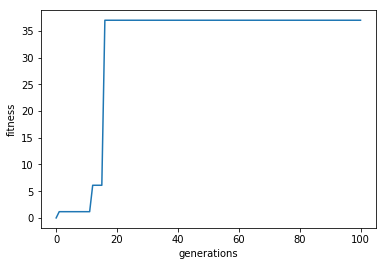

In [385]:
import matplotlib.pyplot as plt
plt.plot(g.evolutionary_history)
plt.xlabel('generations')
plt.ylabel('fitness')

In [386]:
best_weights

[array([[0.74682069, 0.32715987, 0.63424651, 0.40314   , 0.28023775],
        [0.9322168 , 0.52008344, 0.9532515 , 0.95673727, 0.41918324]]),
 array([[ 0.1420551 ,  0.87006956,  1.08950219],
        [ 0.23891473,  0.53580561, -0.07493486],
        [ 0.39369449,  0.34183341, -0.22922182],
        [ 0.6244839 ,  0.1418231 ,  0.13983519],
        [ 0.33632726,  0.74115524,  1.00166438]])]

In [387]:
evolved_ann = FFNN(best_weights)
evolved_ann([1,1])

array([0.79173936, 0.88081118, 0.81090219])

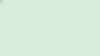

In [388]:
predicted_outputs = evolved_ann(training_inputs)

predicted_image_array = np.zeros_like(image_array)
i = 0
for row,rgbs in enumerate(predicted_image_array):
  for column in range(len(rgbs)):
    r,g,b = predicted_outputs[i]
    predicted_image_array[row][column] = [r*255,g*255,b*255]
    i += 1
Image.fromarray(predicted_image_array)

# Extreme Learning Machine

In [0]:
import numpy as np

class ELM:
  def __init__(self, n_inputs: int, n_hidden = 3000):
    self.random_weights = np.random.normal(size=[n_inputs, n_hidden])
    
  def learn(self, X: np.ndarray, Y: np.ndarray):
    H = self._hidden_layer(X)
    self.output_weights = np.linalg.pinv(H) @ Y
    
  def _f(self, x: np.ndarray): 
    return 1. / (1. + np.exp(-x)) #activation function: sigmoid
    
  def _hidden_layer(self, inputs: np.ndarray): 
    return self._f(inputs @ self.random_weights)
  
  def _output_layer(self, hidden: np.ndarray): 
    return hidden @ self.output_weights
  
  def __call__(self, inputs: np.ndarray):  #infer
    return self._output_layer(self._hidden_layer(inputs))

In [0]:
elm = ELM(2)
elm.learn(np.array(training_inputs), np.array(training_outputs))

In [0]:
elm([1,1])

array([0.95012379, 0.94977713, 0.94932604])

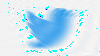

In [0]:
predicted_outputs = elm(training_inputs)

predicted_image_array = np.zeros_like(image_array)
i = 0
for row,rgbs in enumerate(predicted_image_array):
  for column in range(len(rgbs)):
    r,g,b = predicted_outputs[i]
    predicted_image_array[row][column] = [r*255,g*255,b*255]
    i += 1
Image.fromarray(predicted_image_array)